In [1]:
import os
import pandas as pd
sp_data_dict = dict()
for file_name in os.listdir("/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터"):
    sp_data = pd.read_csv("/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터/" + file_name,
                          parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'AppleGothic'
rcParams['axes.unicode_minus'] = False

In [2]:
#분석용 데이터

import numpy as np
mom_data = pd.DataFrame()
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    sp = sp_data["Close"].values
    
    # 모멘텀 계산
    mom_5 = (sp[5:] - sp[:-5]) / sp[:-5] * 100
    mom_10 = (sp[10:] - sp[:-10]) / sp[:-10] * 100
    mom_20 = (sp[20:] - sp[:-20]) / sp[:-20] * 100
    mom_5 = np.insert(mom_5, [0] * 5, np.nan)
    mom_10 = np.insert(mom_10, [0] * 10, np.nan)
    mom_20 = np.insert(mom_20, [0] * 20, np.nan)
    
    # 모멘텀 변수 추가
    temp = pd.DataFrame({"Date":sp_data['Date'].values})
    temp["모멘텀_5"] = mom_5
    temp["모멘텀_10"] = mom_10
    temp["모멘텀_20"] = mom_20
    
    # 수익률 추가 
    ror_5 = np.insert(mom_5, [-1] * 5, np.nan)[5:]
    ror_10 = np.insert(mom_10, [-1] * 10, np.nan)[10:]
    ror_20 = np.insert(mom_20, [-1] * 20, np.nan)[20:]
    temp["수익률_5"] = ror_5
    temp["수익률_10"] = ror_10
    temp["수익률_20"] = ror_20
    
    temp.dropna(inplace = True)
    mom_data = pd.concat([mom_data, temp], axis = 0, ignore_index = True)

In [3]:
#가중 매매 구현

result = []
date_list = sorted(mom_data["Date"].unique())
for date in date_list:
    temp = mom_data.loc[mom_data['Date'] == date]
    for n in [5, 10, 20]:
        temp["그룹"] = pd.qcut(temp['모멘텀_' + str(n)], 5,
                               labels = range(5)).astype(int)
        for group in range(5):
            ror_list = temp.loc[temp["그룹"] == group, "수익률_" + str(n)].values
            inve_per_stock = 10 ** 8 / sum(temp["그룹"] == group)
            profit = (inve_per_stock * ror_list / 100).sum()
            profit_ratio = profit / 10 ** 8 * 100
            result.append([n, group, profit_ratio])

result = pd.DataFrame(result, columns = ["영업일", "그룹", "수익률"])

<Axes: xlabel='영업일,그룹'>

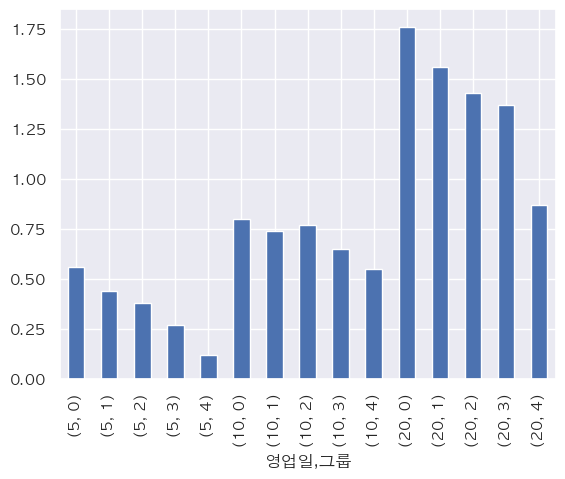

In [4]:
#시각화

result.groupby(['영업일', '그룹'])['수익률'].mean().round(2).plot(kind = 'bar')

<Axes: xlabel='영업일,그룹'>

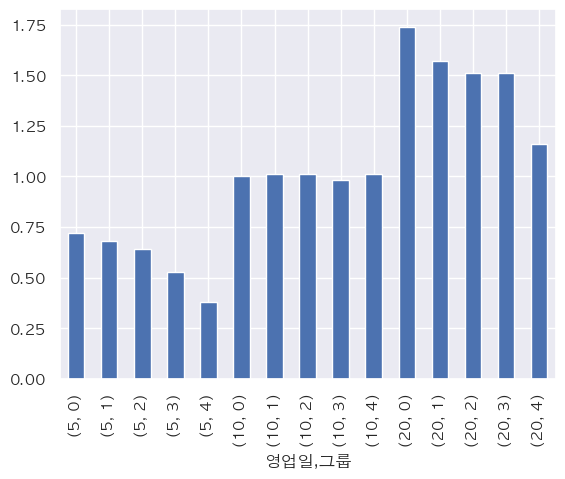

In [5]:
result.groupby(['영업일', '그룹'])['수익률'].median().round(2).plot(kind = 'bar')

In [6]:
display(result.groupby(['영업일', '그룹'])['수익률'].describe().round(2))

count  mean   std    min   25%   50%   75%    max
영업일 그룹                                                    
5   0   2608.0  0.56  3.73 -33.53 -1.20  0.72  2.42  35.95
    1   2608.0  0.44  3.21 -30.04 -0.95  0.68  1.99  29.16
    2   2608.0  0.38  2.90 -29.17 -0.88  0.64  1.86  24.47
    3   2608.0  0.27  2.73 -24.72 -0.89  0.53  1.76  19.87
    4   2608.0  0.12  2.83 -20.75 -1.30  0.38  1.84  13.96
10  0   2608.0  0.80  5.27 -42.25 -1.94  1.00  3.51  58.22
    1   2608.0  0.74  4.52 -41.11 -1.47  1.01  2.99  46.68
    2   2608.0  0.77  4.12 -37.60 -1.22  1.01  2.96  39.06
    3   2608.0  0.65  3.83 -32.39 -1.25  0.98  2.87  29.19
    4   2608.0  0.55  4.00 -27.43 -1.72  1.01  3.09  18.95
20  0   2608.0  1.76  7.37 -42.81 -2.29  1.74  5.70  78.52
    1   2608.0  1.56  6.41 -39.58 -1.73  1.57  5.04  65.09
    2   2608.0  1.43  5.83 -38.99 -1.51  1.51  4.54  52.69
    3   2608.0  1.37  5.43 -33.73 -1.43  1.51  4.47  43.19
    4   2608.0  0.87  5.84 -40.90 -2.66  1.16  4.54  23.26

In [7]:
#분석용 데이터 생성

dmi_data_dict = dict()
for stock_name in sp_data_dict.keys():
    # 데이터 정의
    sp_data = sp_data_dict[stock_name]
    high_price = sp_data["High"].values
    low_price = sp_data["Low"].values
    close_price = sp_data["Close"].values
    
    # 당일과 전일의 고가, 저가, 종가 정의
    cur_high_price = high_price[1:]
    pre_high_price = high_price[:-1]
    cur_low_price = low_price[1:]
    pre_low_price = low_price[:-1]
    cur_close_price = close_price[1:]
    pre_close_price = close_price[:-1]
    
    # PDM과 MDM 계산
    PDM = cur_high_price - pre_high_price
    PDM[PDM < 0] = 0
    MDM = cur_low_price - pre_low_price
    MDM[MDM < 0] = 0
    
    # TR 계산
    TR1 = np.abs(cur_high_price - cur_low_price)
    TR2 = np.abs(cur_high_price - pre_close_price)
    TR3 = np.abs(cur_low_price - pre_close_price)
    TR = np.vstack([TR1, TR2, TR3]).max(axis = 0)
    
    dmi_data = pd.DataFrame({"Close":close_price})    
    dmi_data.drop(0, inplace = True)
    dmi_data["PDM"] = PDM
    dmi_data["MDM"] = MDM
    dmi_data["TR"] = TR
    for n in [5, 10, 20]:
        PDM_n = dmi_data["PDM"].rolling(n).mean()
        MDM_n = dmi_data["MDM"].rolling(n).mean()
        TR_n = dmi_data["TR"].rolling(n).mean()
        PDI_n = PDM_n / TR_n
        MDI_n = MDM_n / TR_n
        DX_n = (PDI_n - MDI_n) / (PDI_n + MDI_n) * 100
        ADX_n = DX_n.rolling(n).mean()
        
        dmi_data["PDI_" + str(n)] = PDI_n
        dmi_data["MDI_" + str(n)] = MDI_n
        dmi_data["ADX_" + str(n)] = ADX_n
    
    dmi_data.drop(['PDM', 'MDM', 'TR'], axis = 1, inplace = True)
    dmi_data_dict[stock_name] = dmi_data

In [8]:
#pdi / mdi 활용 매매 전략 검증
result_dict = {5:[], 10:[], 20:[]}
for stock_name in dmi_data_dict.keys():
    dmi_data = dmi_data_dict[stock_name]
    for n in [5, 10, 20]:
        PDI = dmi_data["PDI_" + str(n)].values
        MDI = dmi_data["MDI_" + str(n)].values
        # 매수 시점 목록 정의
        bp_list = (PDI[1:] > MDI[1:]) & (PDI[:-1] <= MDI[:-1])
        bp_list = np.insert(bp_list, 0, False)
        bp_list = dmi_data.index[bp_list]
        # 매도 시점 목록 정의
        sp_list = (PDI[1:] < MDI[1:]) & (PDI[:-1] > MDI[:-1])
        sp_list = np.insert(sp_list, 0, False)
        sp_list = dmi_data.index[sp_list]

        for bp in bp_list:
            if (sum(bp<sp_list) > 0) and (bp + 1 <= dmi_data.index[-1]):
                buy_price = dmi_data.loc[bp + 1, "Close"]
                sp = sp_list[sp_list > bp][0] + 1
                if sp <= dmi_data.index[-1]:
                    sell_price = dmi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    result_dict[n].append(profit)
            else:
                break

result = pd.DataFrame()
for n in [5, 10, 20]:
    result = pd.concat([result, pd.Series(result_dict[n]).describe()], axis = 1)
result.columns = [5, 10, 20]
display(result)

,5,10,20
count,575915.000000,396316.000000,256315.000000
mean,0.308006,0.499711,0.780359
std,8.587826,11.102165,15.767842
min,-91.598630,-92.033184,-92.322886
25%,-2.681626,-2.957486,-3.215926
50%,-0.162075,-0.195312,-0.242601
75%,2.286585,2.443609,2.473498
max,584.235774,1211.111111,2258.490566


In [9]:
#pdi / mdi / adx 매매전략 검증

result_dict = {5:[], 10:[], 20:[]}
for stock_name in dmi_data_dict.keys():
    dmi_data = dmi_data_dict[stock_name]
    for n in [5, 10, 20]:
        PDI = dmi_data["PDI_" + str(n)].values
        MDI = dmi_data["MDI_" + str(n)].values
        ADX = dmi_data["ADX_" + str(n)].values

        bp_list = ((PDI[1:] > MDI[1:]) & (ADX[1:] >= 25)) 
        bp_list &= ((PDI[:-1] <= MDI[:-1]) | (ADX[:-1] < 25))
        bp_list = np.insert(bp_list, 0, False)
        bp_list = dmi_data.index[bp_list] 

        sp_list = ((PDI[1:] <= MDI[1:]) & (ADX[1:] >= 25)) 
        sp_list &= ((PDI[:-1] > MDI[:-1]) | (ADX[:-1] < 25))
        sp_list = np.insert(sp_list, 0, False)
        sp_list = dmi_data.index[sp_list] 

        for bp in bp_list:
            if (sum(bp < sp_list) > 0) and (bp + 1 <= dmi_data.index[-1]):
                buy_price = dmi_data.loc[bp + 1, "Close"]
                sp = sp_list[sp_list > bp][0] + 1
                if sp <= dmi_data.index[-1]:
                    sell_price = dmi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    result_dict[n].append(profit)
            else:
                break

result = pd.DataFrame()
for n in [5, 10, 20]:
    result = pd.concat([result, pd.Series(result_dict[n]).describe()], axis = 1)
result.columns = [5, 10, 20]
display(result)

,5,10,20
count,198444.000000,72695.000000,22459.000000
mean,3.206876,5.023546,7.530121
std,34.848238,45.550595,65.457218
min,-98.893099,-97.829648,-99.105313
25%,-7.101462,-9.027778,-12.370497
50%,-0.623971,-1.037613,-1.694915
75%,4.977376,5.637255,7.019860
max,2518.985696,1309.395973,2669.335938


In [10]:
#엔빌롭

#데이터 세팅
env_data_dict = dict()
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    env_data = sp_data.copy() # sp_data 복제
    low_price = env_data["Low"].values
    high_price = env_data["High"].values
    for n in [5, 10, 20]:
        env_data["MA_" + str(n)] = env_data["Close"].rolling(n).mean()
        for a in [0.05, 0.1, 0.15, 0.2]:
            env_data["지지선_{}_{}".format(n, a)] = env_data["MA_" + str(n)] * (1-a)
            env_data["저항선_{}_{}".format(n, a)] = env_data["MA_" + str(n)] * (1+a)
    env_data_dict[stock_name] = env_data

In [11]:
#전략 검증 / 시각화

mean_result = []
median_result = []
for n in [5, 10, 20]:
    for a in [0.05, 0.1, 0.15, 0.2]:
        ror_list = []
        for stock_name in env_data_dict.keys():
            env_data = env_data_dict[stock_name]
            low_price = env_data["Low"].values
            high_price = env_data["High"].values
            res = env_data["저항선_{}_{}".format(n, a)].values
            sup = env_data["지지선_{}_{}".format(n, a)].values
            
            bp_list = (low_price[1:] <= sup[1:]) & (low_price[:-1] > sup[:-1])
            bp_list = np.insert(bp_list, 0, False)
            bp_list = env_data.index[bp_list] 
            
            sp_list = (high_price[1:] >= res[1:]) & (high_price[:-1] < res[:-1])
            sp_list = np.insert(sp_list, 0, False)
            sp_list = env_data.index[sp_list]
            
            for bp in bp_list:
                if (sum(bp < sp_list) > 0) and (bp + 1 <= env_data.index[-1]):
                    buy_price = env_data.loc[bp + 1, "Close"]
                    sp = sp_list[sp_list > bp][0] + 1
                    if sp <= env_data.index[-1]:
                        sell_price = env_data.loc[sp, "Close"]
                        ror = (sell_price - buy_price) / buy_price * 100
                        ror_list.append(ror)
                else:
                    break

        mean_result.append(np.mean(ror_list))
        median_result.append(np.quantile(ror_list, 0.5))
    
mean_result = np.array(mean_result).reshape(3, 4)
median_result = np.array(median_result).reshape(3, 4)

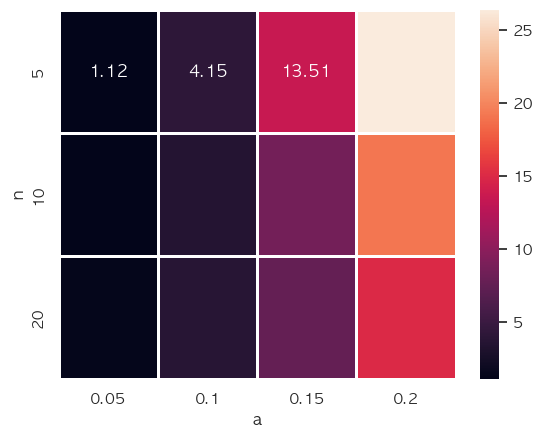

In [12]:
sns.heatmap(mean_result, annot = True, fmt = ".2f", linewidth = 1)
plt.yticks([0.5, 1.5, 2.5], [5, 10, 20])
plt.xticks([0.5, 1.5, 2.5, 3.5], [0.05, 0.1, 0.15, 0.2])
plt.ylabel("n")
plt.xlabel("a")
plt.show()

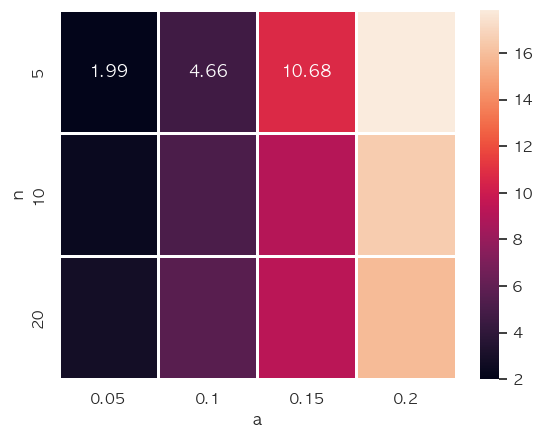

In [13]:
sns.heatmap(median_result, annot = True, fmt = ".2f", linewidth = 1)
plt.yticks([0.5, 1.5, 2.5], [5, 10, 20])
plt.xticks([0.5, 1.5, 2.5, 3.5], [0.05, 0.1, 0.15, 0.2])
plt.ylabel("n")
plt.xlabel("a")
plt.show()

In [14]:
#시장지표 세팅

import os
import pandas as pd
sp_data_dict = dict()
for file_name in os.listdir("/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터"):
    sp_data = pd.read_csv("/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터/" + file_name,
                          parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'AppleGothic'
rcParams['axes.unicode_minus'] = False

In [16]:
#EOM 지수
#분석용 데이터

import numpy as np
eom_data_dict = dict()
for stock_name in sp_data_dict.keys():
    eom_data = sp_data_dict[stock_name].copy()
    high_price = eom_data["High"].values
    low_price = eom_data["Low"].values
    volume = eom_data["Volume"].values
    MM = ((high_price[1:] + low_price[1:]) - (high_price[:-1] + low_price[:-1])) / 2
    BR = (volume[1:] / 10000) / (high_price[1:] - low_price[1:])
    EOM = MM / BR
    eom_data.drop(0, inplace = True)
    eom_data["EOM"] = EOM
    eom_data["EOM_5"] = eom_data["EOM"].rolling(5).mean()
    eom_data["EOM_10"] = eom_data["EOM"].rolling(10).mean()
    eom_data["EOM_20"] = eom_data["EOM"].rolling(20).mean()
    eom_data_dict[stock_name] = eom_data

In [17]:
#전략 구현 / 검증
def ror_using_EOM(eom_data_dict, EOM_col):
    ror_list = []
    for stock_name in eom_data_dict.keys():
        eom_data = eom_data_dict[stock_name]
        EOM = eom_data[EOM_col].values
        buy_point_list = (EOM[1:] > 0) & (EOM[:-1] <= 0)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = eom_data.index[buy_point_list]

        sell_point_list = (EOM[1:] < 0) & (EOM[:-1] >= 0)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = eom_data.index[sell_point_list]
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= eom_data.index[-1]):
                buy_price = eom_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= eom_data.index[-1]:
                    sell_price = eom_data.loc[sp, "Close"]
                    ror = (sell_price - buy_price) / buy_price * 100
                    ror_list.append(ror)
            else:
                break
    return np.array(ror_list)



In [18]:
EOM_1_ror = ror_using_EOM(eom_data_dict, "EOM")
EOM_5_ror = ror_using_EOM(eom_data_dict, "EOM_5")
EOM_10_ror = ror_using_EOM(eom_data_dict, "EOM_10")
EOM_20_ror = ror_using_EOM(eom_data_dict, "EOM_20")

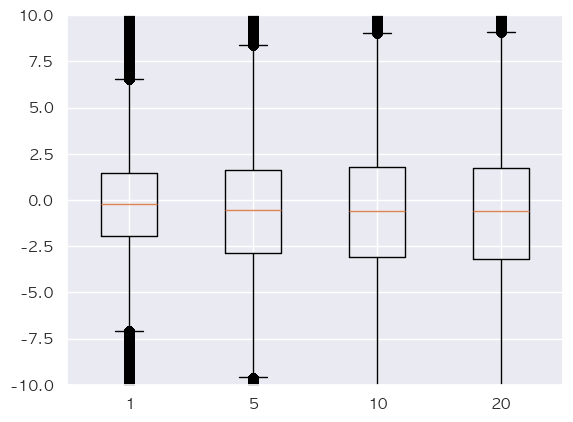

In [19]:
plt.boxplot([EOM_1_ror, EOM_5_ror, EOM_10_ror, EOM_20_ror])
plt.xticks([1, 2, 3, 4], [1, 5, 10, 20])
plt.ylim(-10, 10)
plt.show()

In [20]:
result = pd.concat([pd.Series(EOM_1_ror).describe(),
                    pd.Series(EOM_5_ror).describe(),
                    pd.Series(EOM_10_ror).describe(),
                    pd.Series(EOM_20_ror).describe()], axis = 1)
display(result.round(3))

,0,1,2,3
count,1037616.000,447206.000,312919.000,214228.000
mean,0.176,0.272,0.518,0.679
std,5.646,8.321,10.305,12.343
min,-90.295,-91.836,-71.042,-84.088
25%,-1.961,-2.857,-3.077,-3.175
50%,-0.218,-0.542,-0.571,-0.621
75%,1.444,1.641,1.765,1.729
max,664.131,588.158,857.627,1138.938


In [21]:
#RSI

#분석 데이터
rsi_data_dict = dict()
for stock_name in sp_data_dict.keys():
    rsi_data = sp_data_dict[stock_name][['Close']].copy()
    price = rsi_data["Close"].values
    rise = price[1:] - price[:-1]
    rise[rise < 0] = 0
    fall = price[:-1] - price[1:]
    fall[fall < 0] = 0
    
    rsi_data.drop(0, inplace = True)
    rsi_data["상승폭"] = rise
    rsi_data["하락폭"] = fall
    
    for n in [5, 10, 20]:
        sum_rise_n = rsi_data["상승폭"].rolling(n).sum()
        sum_fall_n = rsi_data["하락폭"].rolling(n).sum()
        rsi_data["RSI_" + str(n)] = sum_rise_n / (sum_rise_n + sum_fall_n)
    rsi_data_dict[stock_name] = rsi_data

In [22]:
#RSI 매도 / 매수

result = pd.DataFrame()
for n in [5, 10, 20]:
    record = []
    for stock_name in rsi_data_dict.keys():
        rsi_data = rsi_data_dict[stock_name]
        RSI = rsi_data["RSI_" + str(n)].values
        
        buy_point_list = (RSI[1:] < 0.4) & (RSI[:-1] >= 0.4)  # 0.4 미만이면 매수로 변경
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = rsi_data.index[buy_point_list] 
        sell_point_list = (RSI[1:] >= 0.8) & (RSI[:-1] < 0.8) # 0.8이상이면 매도로 변경
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = rsi_data.index[sell_point_list] 
        
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= rsi_data.index[-1]):
                buy_price = rsi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= rsi_data.index[-1]:
                    sell_price = rsi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
display(result)

,5,10,20
count,470003.000000,307754.000000,181137.000000
mean,0.924728,2.746547,12.953491
std,10.791871,17.985451,42.621217
min,-96.470503,-96.073487,-95.409083
25%,-3.213681,-5.970149,-11.076605
50%,1.443001,3.237546,8.643429
75%,5.610098,10.997250,29.787234
max,622.311176,564.174685,1302.073365


In [23]:
#RSI 매수 / 매도 변경
result = pd.DataFrame()
for n in [5, 10, 20]:
    record = []
    for stock_name in rsi_data_dict.keys():
        rsi_data = rsi_data_dict[stock_name]
        RSI = rsi_data["RSI_" + str(n)].values
        
        buy_point_list = (RSI[1:] >= 0.5) & (RSI[:-1] < 0.5)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = rsi_data.index[buy_point_list] 
        sell_point_list = (RSI[1:] < 0.5) & (RSI[:-1] >= 0.5)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = rsi_data.index[sell_point_list] 
        
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= rsi_data.index[-1]):
                buy_price = rsi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= rsi_data.index[-1]:
                    sell_price = rsi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
display(result)

,5,10,20
count,492861.000000,340737.000000,237654.000000
mean,0.270583,0.573185,0.719588
std,8.730861,11.345124,14.149691
min,-93.047619,-90.734824,-90.075529
25%,-2.826380,-3.105023,-3.278689
50%,-0.586166,-0.620975,-0.705755
75%,1.449275,1.483051,1.343560
max,994.017094,975.498575,1241.880342


In [24]:
#MFI 
#분석용 데이터
mfi_data_dict = dict()
for stock_name in sp_data_dict.keys():
    mfi_data = sp_data_dict[stock_name][['Close']].copy()
    sp_data = sp_data_dict[stock_name]
    close_price = sp_data["Close"].values
    low_price = sp_data["Low"].values
    high_price = sp_data["High"].values
    volume = sp_data["Volume"].values
    
    MF = volume[1:] * (high_price[1:] + low_price[1:] + close_price[1:]) / 3
    PMF = np.zeros(len(MF))
    NMF = np.zeros(len(MF))
    
    PMF[close_price[1:] > close_price[:-1]] = MF[close_price[1:] > close_price[:-1]]
    NMF[close_price[1:] < close_price[:-1]] = MF[close_price[1:] < close_price[:-1]]
    
    mfi_data.drop(0, inplace = True)
    mfi_data["PMF"] = PMF
    mfi_data["NMF"] = NMF
    
    for n in [5, 10, 20]:
        PMF_n = mfi_data["PMF"].rolling(n).sum()
        NMF_n = mfi_data["NMF"].rolling(n).sum()
        MR = PMF_n / NMF_n
        mfi_data["MFI_" + str(n)] = MR / (1 + MR)
        
    mfi_data_dict[stock_name] = mfi_data

In [25]:
#MFI 매수 / 매도
result = pd.DataFrame()
for n in [5, 10, 20]:
    record = []
    for stock_name in mfi_data_dict.keys():
        mfi_data = mfi_data_dict[stock_name]
        MFI = mfi_data["MFI_" + str(n)].values
        
        buy_point_list = (MFI[1:] < 0.3) & (MFI[:-1] >= 0.3)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = mfi_data.index[buy_point_list] 
        sell_point_list = (MFI[1:] >= 0.8) & (MFI[:-1] < 0.8)   #0.8 이상이면 매도로 변경
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = mfi_data.index[sell_point_list] 
        
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= mfi_data.index[-1]):
                buy_price = mfi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= mfi_data.index[-1]:
                    sell_price = mfi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
display(result)

,5,10,20
count,379646.000000,205778.000000,89515.000000
mean,1.257520,2.590985,7.652062
std,12.030341,16.563806,28.333468
min,-96.807292,-96.164155,-96.844133
25%,-3.583062,-5.090909,-6.565657
50%,1.618705,3.079179,6.058752
75%,6.429521,10.410959,19.214500
max,587.077308,602.345906,859.235669


In [26]:
result = pd.DataFrame()
for n in [5, 10, 20]:
    record = []
    for stock_name in mfi_data_dict.keys():
        mfi_data = mfi_data_dict[stock_name]
        MFI = mfi_data["MFI_" + str(n)].values
        
        buy_point_list = (MFI[1:] >= 0.5) & (MFI[:-1] < 0.5)
        buy_point_list = np.insert(buy_point_list, 0, False)
        buy_point_list = mfi_data.index[buy_point_list] 
        sell_point_list = (MFI[1:] < 0.5) & (MFI[:-1] >= 0.5)
        sell_point_list = np.insert(sell_point_list, 0, False)
        sell_point_list = mfi_data.index[sell_point_list] 
        
        for bp in buy_point_list:
            if (sum(bp < sell_point_list) > 0) and (bp + 1 <= mfi_data.index[-1]):
                buy_price = mfi_data.loc[bp + 1, "Close"]
                sp = sell_point_list[sell_point_list > bp][0] + 1
                if sp <= mfi_data.index[-1]:
                    sell_price = mfi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    record.append(profit)
            else:
                break
    result = pd.concat([result, pd.Series(record).describe()], axis = 1)

result.columns = [5, 10, 20]
display(result)

,5,10,20
count,468632.000000,314262.000000,205797.000000
mean,0.326084,0.650426,0.963305
std,9.312533,12.533188,16.580246
min,-85.489650,-85.283546,-90.828829
25%,-2.966102,-3.361345,-3.793103
50%,-0.554529,-0.613497,-0.700000
75%,1.674277,1.838235,1.868630
max,889.276139,1322.222222,1011.111111


In [27]:
#기본 데이터 세팅 
#평균 회귀 전략

import os
import pandas as pd
sp_data_dict = dict()
for file_name in os.listdir("/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터"):
    sp_data = pd.read_csv("/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터/" + file_name,
                          parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data
    import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'AppleGothic'
rcParams['axes.unicode_minus'] = False

In [28]:
#주가 회복 비율 계산

def count_loss_and_recover(sp_data, n1, n2, m1, m2):
    num_loss = 0
    num_recover = 0
    cur_price_list = sp_data["Close"].values
    n1_rmax_list = sp_data["Close"].rolling(n1).max().values
    n2_rmax_list = sp_data["Close"].rolling(n2).max().values
    pre_loss_list = (n1_rmax_list - cur_price_list) / n1_rmax_list * 100
    
    for i in range(n1, len(sp_data) - n2):
        if pre_loss_list[i] >= m1:
            num_loss += 1
            if n2_rmax_list[i+n2] >= cur_price_list[i] * (1+m2 / 100):
                num_recover += 1
    return num_recover, num_loss

import numpy as np
def sum_count_loss_and_recover(sp_data_dict, n1, n2, m1, m2):
    total_num_recover, total_num_loss = 0, 0
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        num_recover, num_loss = count_loss_and_recover(sp_data, n1, n2, m1, m2)
        total_num_recover += num_recover
        total_num_loss += num_loss
    if total_num_loss > 0:
        result = total_num_recover / total_num_loss
    else:
        result = np.nan
    
    return result

In [29]:
#회복률 시각화

def make_heatmap(n1, n2, m1_range, m2_range):
    graph_data = []
    for m1 in m1_range:
        record = []
        for m2 in m2_range:
            result = sum_count_loss_and_recover(sp_data_dict, n1, n2, m1, m2)
            record.append(result)
        graph_data.append(record)

    sns.heatmap(graph_data, annot = True, fmt = ".2f", linewidth = 1)
    plt.xticks(np.arange(0.5, len(m2_range), 1), m2_range)
    plt.yticks(np.arange(0.5, len(m1_range), 1), m1_range)
    plt.show()

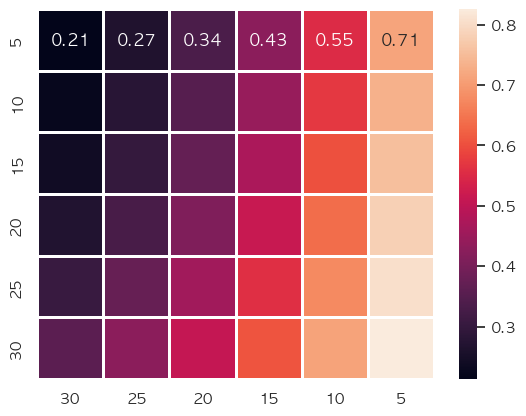

In [30]:
make_heatmap(60, 60, range(5, 31, 5), range(30, 0, -5))

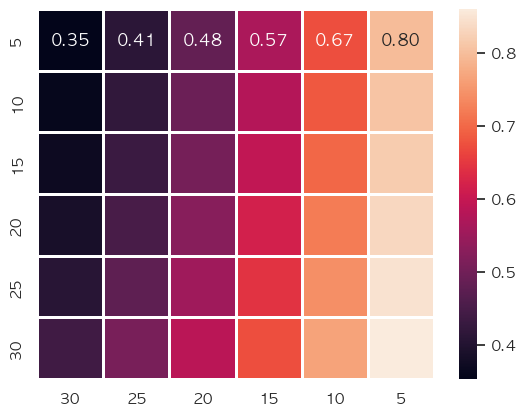

In [31]:
make_heatmap(120, 120, range(5, 31, 5), range(30, 0, -5))

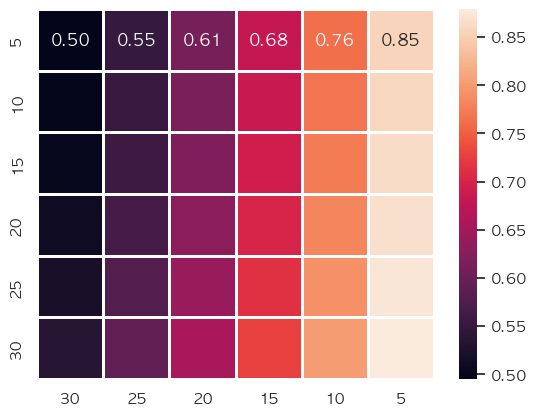

In [32]:
make_heatmap(240, 240, range(5, 31, 5), range(30, 0, -5))

In [33]:
#평균회귀 전략 구현
def calc_ror_using_mean_reg(sp_data_dict, n1, n2, m1, m2):
    ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        cur_price_list = sp_data["Close"].values
        n1_rmax_list = sp_data["Close"].rolling(n1).max().values
        pre_loss_list = (n1_rmax_list - cur_price_list) / n1_rmax_list * 100
        for i in range(n1, len(sp_data) - n2 + 1):
            if pre_loss_list[i] >= m1:
                bp = cur_price_list[i] # 매수가
                cand_sp_list = sp_data.loc[i:i+n2, "Close"].values # 매도가 후보 
                if cand_sp_list.max() > bp * (1+m2/100): # 원하는 수준에 도달하면
                    sp = cand_sp_list[cand_sp_list > bp * (1+m2/100)][0]
                else:
                    sp = cand_sp_list[-1]
                ror = (sp - bp) / bp * 100
                ror_list.append(ror)
    return ror_list

In [34]:
#검증
n1 = 20; n2 = 20; m1 = 5; m2 = 5
ror_list = calc_ror_using_mean_reg(sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    2461008.000
mean           0.740
std           10.995
min          -89.120
25%           -5.294
50%            5.172
75%            6.852
max          900.114
dtype: float64

In [38]:
n1 = 60; n2 = 120; m1 = 20; m2 = 10
profit_list = calc_ror_using_mean_reg(sp_data_dict, n1, n2, m1, m2)
display(pd.Series(profit_list).describe().round(3))

count    1063384.000
mean           5.408
std           17.906
min          -96.688
25%           10.003
50%           11.303
75%           13.978
max          900.000
dtype: float64

In [37]:
n1 = 240; n2 = 240; m1 = 30; m2 = 30
profit_list = calc_ror_using_mean_reg(sp_data_dict, n1, n2, m1, m2)
display(pd.Series(profit_list).describe().round(3))

count    1430601.000
mean          10.136
std           32.543
min          -96.419
25%          -16.208
50%           30.315
75%           33.797
max          945.303
dtype: float64

In [39]:
# 종목 정보 가져오기
stock_info = pd.read_csv("/Users/yang-eun-yeol/Desktop/my_quant/데이터/종목정보.txt", sep = "\t", encoding = "euc-kr")
market_cap = pd.read_excel("/Users/yang-eun-yeol/Desktop/my_quant/데이터/211104_시가총액.xlsx")
stock_info = pd.read_excel("/Users/yang-eun-yeol/Desktop/my_quant/데이터/211104_시가총액.xlsx")
KOSPI_list = stock_info.loc[stock_info["시장구분"] == "KOSPI", "종목명"].values
KOSDAQ_list = stock_info.loc[stock_info["시장구분"] == "KOSDAQ", "종목명"].values
TOP100_list = stock_info.sort_values(by = "시가총액", ascending = False)["종목명"].values[:100]
KOSPI_sp_data_dict = dict()
KOSDAQ_sp_data_dict = dict()
TOP100_sp_data_dict = dict()

for stock_name in sp_data_dict.keys():
    if stock_name in KOSPI_list:
        KOSPI_sp_data_dict[stock_name] = sp_data_dict[stock_name]
    if stock_name in KOSDAQ_list:
        KOSDAQ_sp_data_dict[stock_name] = sp_data_dict[stock_name]
    if stock_name in TOP100_list:
        TOP100_sp_data_dict[stock_name] = sp_data_dict[stock_name]

In [40]:
#코스피
n1 = 20; n2 = 20; m1 = 5; m2 = 5
ror_list = calc_ror_using_mean_reg(KOSPI_sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    48853.000
mean         0.327
std          9.230
min        -64.417
25%         -4.935
50%          3.727
75%          6.271
max         35.929
dtype: float64

In [41]:
n1 = 60; n2 = 120; m1 = 20; m2 = 10
ror_list = calc_ror_using_mean_reg(KOSPI_sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    15712.000
mean         4.535
std         17.555
min        -76.103
25%          0.533
50%         11.002
75%         13.061
max         42.665
dtype: float64

In [42]:
n1 = 240; n2 = 240; m1 = 30; m2 = 30
ror_list = calc_ror_using_mean_reg(KOSPI_sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    25013.000
mean         2.525
std         31.580
min        -88.706
25%        -21.010
50%          1.227
75%         31.764
max         68.898
dtype: float64

In [43]:
#코스닥
n1 = 20; n2 = 20; m1 = 5; m2 = 5
ror_list = calc_ror_using_mean_reg(KOSDAQ_sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    57560.000
mean         0.664
std         11.197
min        -68.171
25%         -5.935
50%          5.238
75%          7.168
max         94.834
dtype: float64

In [44]:
n1 = 60; n2 = 120; m1 = 20; m2 = 10
ror_list = calc_ror_using_mean_reg(KOSDAQ_sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    29390.000
mean         4.583
std         19.353
min        -93.387
25%          0.506
50%         11.434
75%         14.510
max         94.834
dtype: float64

In [45]:
n1 = 240; n2 = 240; m1 = 30; m2 = 30
ror_list = calc_ror_using_mean_reg(KOSDAQ_sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    39014.000
mean         6.826
std         35.182
min        -95.560
25%        -22.325
50%         30.147
75%         34.146
max         94.834
dtype: float64

In [46]:
#우량
n1 = 20; n2 = 20; m1 = 5; m2 = 5
ror_list = calc_ror_using_mean_reg(TOP100_sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    10760.000
mean         0.306
std          8.353
min        -50.577
25%         -4.529
50%          3.004
75%          6.008
max         32.336
dtype: float64

In [47]:
n1 = 60; n2 = 120; m1 = 20; m2 = 10
ror_list = calc_ror_using_mean_reg(TOP100_sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    2513.000
mean        5.863
std        16.871
min       -76.103
25%        10.141
50%        11.111
75%        13.084
max        40.272
dtype: float64

In [48]:
n1 = 240; n2 = 240; m1 = 30; m2 = 30
ror_list = calc_ror_using_mean_reg(TOP100_sp_data_dict, n1, n2, m1, m2)
display(pd.Series(ror_list).describe().round(3))

count    3983.000
mean        1.556
std        31.258
min       -88.706
25%       -22.079
50%         2.606
75%        31.169
max        68.450
dtype: float64